## This code generates a design file, which specifies all parameters per trial
- Stimuli presented
- Reward contingencies
- Cue (SPD/ACC)
- Timing per phase

Symbols are counterbalanced across participants. Trial orders are pseudorandomized: 
- Cues aren't repeated >4 times 
- stimulus sets / symbols aren't repeated >2 times.

In [8]:
import itertools
import numpy as np
import pandas as pd
from pseudorandomizer import Pseudorandomizer

## Set-up phase timing

In [9]:
# timing parameters
def generate_onsets_fixed_duration(phase_settings,
                                   n_trials=100, trial_duration = 8.28,
                                   n_null_trials=8, null_trial_duration = 6.9,
                                   null_trial_min_row=8, 
                                   null_trial_max_row=8, 
                                   min_n_rows_separate=8):
    # create onsets/durations dataframe
    trial_nr = np.arange(n_trials, dtype=int)
    
    for i in range(100):
        duration_df = pd.DataFrame(index=trial_nr)

        for phase_nr, phase_dict in enumerate(phase_settings):
            duration_df[phase_dict['phase_name']] = np.random.choice(phase_dict['durations'], 
                                                                     p=phase_dict['probabilities'],
                                                                     replace=True, size=n_trials)

        # make sure first trial, pre-trial iti has at least 1 second
        duration_df.iloc[0,0] = np.max([1, duration_df.iloc[0,0]])
        cumulative_durations = duration_df.apply(sum, axis=1)
        post_iti_durations = trial_duration - cumulative_durations

        # find trials where total trial duration is longer than 9 seconds (trial_duration)
        for idx in np.argwhere(cumulative_durations > trial_duration):
            # subtract the overshoot in trial duration from the phase that takes longest
            longest_phase = duration_df.loc[idx, ['fix_cross_1', 'fix_cross_2', 'fix_cross_3', 'fix_cross_4']].apply(np.argmax, axis=1)
            duration_df.loc[idx, longest_phase] += post_iti_durations[idx].values

        # recalc cumulative duration
        cumulative_duration_nopostiti = duration_df.apply(sum, axis=1)
        duration_df['iti_posttrial'] = np.round(trial_duration - cumulative_duration_nopostiti,4)

        if n_null_trials > 0:
            # insert 'null trials'
            good_idx = False
            while not good_idx:
                indx = np.random.choice(np.arange(min_n_rows_separate, 
                                                  duration_df.shape[0]-null_trial_max_row), 
                                        replace=False, size=n_null_trials)
                diffs = np.diff(np.sort(indx))
                if (diffs >= min_n_rows_separate).all():
                    good_idx = True
            duration_df.loc[indx, 'iti_posttrial'] += np.round(null_trial_duration,4)
        duration_df['cumulative'] = duration_df.apply(sum, axis=1)
        if np.sum(duration_df<0).sum() > 0 and i == 99:
            print('WARNING! only negative durations found after 100 attempts')
        else:
            break

    # Some reshaping tricks to extract onsets
    onset_df = duration_df.iloc[:,:-1].copy()
    onset_df.index.name = 'trial_nr'
    onset_df = onset_df.reset_index()
    onset_df = onset_df.melt(id_vars=['trial_nr'], value_name='duration', var_name='phase_name')
    
    # make look-up dict
    look_up = {phase_info['phase_name']: phase_nr for phase_nr, phase_info in enumerate(phase_settings)}
    look_up['iti_posttrial'] = len(look_up)
    onset_df['phase_nr'] = onset_df['phase_name'].replace(look_up)
    
    # sort, calculate durations
    onset_df = onset_df.sort_values(by=['trial_nr', 'phase_nr'])
    onset_df['cumulative_duration'] = onset_df['duration'].cumsum()
    onset_df['onset'] = onset_df['cumulative_duration'].shift(1, fill_value=0)
    
    # clean up
    onset_df = onset_df[['trial_nr', 'phase_nr', 'phase_name', 
                         'onset', 'duration', 'cumulative_duration']].reset_index(drop=True)

    return onset_df, duration_df

# onsets, durations = generate_onsets_fixed_duration(phase_settings)

In [10]:
def generate_block_design(n_trials, ps,
                          stimulus_sets=[0,1,2],
                          include_cue=True,
                          pseudorandomize=True,
                          phase_settings=None, 
                          **kwargs):
    """ Generates design for a single block.
    """
    
    correct_stim_lr = [0, 1]
    if include_cue:
        cues = ['SPD', 'ACC']
    else:
        cues = ['']
    combs = list(itertools.product(stimulus_sets, correct_stim_lr, cues))
    
    # make basic df
    design = pd.DataFrame(combs * int(np.ceil((n_trials/len(combs)))), 
                          columns=['stimulus_set', 'correct_stim_lr', 'cue_txt'])
    
    # randomize / shuffle
    design = design.sample(frac=1).reset_index(drop=True)#.reset_index('trial_ID')
    n_trials_real = design.shape[0]
    design = design.iloc[:n_trials]
    
    if not n_trials == n_trials_real:
        print('WARNING: not totally balanced (%d not a multitude of %d)' %(n_trials, len(combs)))
    
    if pseudorandomize:
        design = Pseudorandomizer(design, max_identical_iters={'stimulus_set': 2,
                                                               'cue_txt': 4}).run()
    
    # Add probabilities (left/right and correct/incorrect - this is redundant, I know)
    design['p_win_left'] = None
    design['p_win_right'] = None
    design['p_win_correct'] = None
    design['p_win_incorrect'] = None
    for stimulus_set, p_win in zip(stimulus_sets, ps):
        p_win_high, p_win_low = p_win[0], p_win[1]
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 0), 'p_win_left'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 1), 'p_win_right'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 1), 'p_win_left'] = p_win_low
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 0), 'p_win_right'] = p_win_low
        design.loc[(design.stimulus_set==stimulus_set), 'p_win_correct'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set), 'p_win_incorrect'] = p_win_low
    
    design['trial_nr'] = np.arange(design.shape[0], dtype='int')
    
    if phase_settings is not None:
#         onsets_long, _ = generate_onsets_fixed_duration(phase_settings=phase_settings, n_trials=n_trials)
#         onsets_wide = pd.pivot_table(onsets_long, values='onset', index='trial_nr', columns='phase_name').reset_index()
        onsets, durations = generate_onsets_fixed_duration(phase_settings=phase_settings, n_trials=n_trials, **kwargs)
        durations['trial_nr'] = np.arange(durations.shape[0], dtype='int')
        durations = durations.rename(columns={'cumulative': 'total_duration'})
        design = pd.merge(design, durations, on='trial_nr')
        
        # make sure to generate the onsets long file
        acc_trials = design.loc[design['cue_txt'] == 'ACC', 'trial_nr']
        spd_trials = design.loc[design['cue_txt'] == 'SPD', 'trial_nr']
        
        onsets.loc[(np.in1d(onsets['trial_nr'], acc_trials) & (onsets.phase_name == 'cue')), 'phase_name'] = 'cue_acc'
        onsets.loc[(np.in1d(onsets['trial_nr'], spd_trials) & (onsets.phase_name == 'cue')), 'phase_name'] = 'cue_spd'
        
        # clean up
        design = design[['trial_nr', 'stimulus_set', 'correct_stim_lr', 'cue_txt', 'p_win_left', 'p_win_right', 'p_win_correct', 'p_win_incorrect',
                         'fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 
                         'highlight', 'fix_cross_4', 
                         'feedback', 'iti_posttrial', 'total_duration']]
        return design, onsets
    
    return design

# design, onsets = generate_block_design(n_trials=96, 
#                                        stimulus_sets=[0, 1, 2], 
#                                        ps=[[0.8, 0.2], [0.7, 0.3], [0.6, 0.4]],
#                                        phase_settings=phase_settings)

In [11]:
def counterbalance_stimuli(subject_id, all_stimuli=None,
                           reverse_pair=(False, True),
                           shifts_within_blocks=(0,1,2),
                           shifts_across_blocks=(0,1,2),
                           verbose=True):
    """ reverse_pairs = switch first and second half of the sets (useful for different block types) 
    
    """
    import itertools
    from copy import deepcopy
    
    if all_stimuli is None:
        print('WARNING: default stimuli sets used')
        all_stimuli = [[[1, 2], [3, 4], [5, 6]],       # block 1
                       [[7, 8], [9, 10], [11, 12]],    # block 2
                       [[13, 14], [15,16], [17, 18]]]  # block 3

#     options
#     reverse_pair = [False, True]
#     shifts_within_blocks = [0, 1, 2]
#     shifts_across_blocks = [0, 1, 2]

    cb_df = pd.DataFrame(list(itertools.product(shifts_across_blocks,
                                                shifts_within_blocks, 
                                                reverse_pair)),
                         columns=['shifts_across_blocks', 'shifts_within_blocks', 'reverse_pair'])
    n_unique_permutations = cb_df.shape[0]

    pp_zero_based = int(subject_id) - 1
    row_iloc = int(pp_zero_based - np.floor(pp_zero_based / n_unique_permutations) * n_unique_permutations)

    settings = cb_df.iloc[row_iloc]
    stimuli_this_sub = deepcopy(all_stimuli)

    # shift blocks
    for i in range(settings.shifts_across_blocks):
        stimuli_this_sub.insert(len(stimuli_this_sub), stimuli_this_sub.pop(0))

    # loop over stimuli per block
    for block_n in range(len(stimuli_this_sub)):

        # reverse pair order
        for stimulus_set in stimuli_this_sub[block_n]:
            if settings.reverse_pair:
                stimuli_this_sub[block_n] = [x[::-1] for x in stimuli_this_sub[block_n]]  # reverse inner order

        # shift pairs within block
        for i in range(settings.shifts_within_blocks):
            stimuli_this_sub[block_n].insert(len(stimuli_this_sub[block_n]), stimuli_this_sub[block_n].pop(0))

    if verbose:
        print('Stimuli this subject: {}'.format(stimuli_this_sub))
    return stimuli_this_sub

In [12]:
def get_stimuli(subject_id, design, stimulus_sets):
    
    all_stim = counterbalance_stimuli(subject_id, 
                                      all_stimuli=stimulus_sets)
    # flatten
    all_stim = [item for sublist in all_stim for item in sublist]
    
    design['stim_left'] = None
    design['stim_right'] = None
    design['stim_high'] = None
    design['stim_low'] = None

    
    for i in range(len(all_stim)):
        idx_this_stim = design.stimulus_set == i
        design.loc[idx_this_stim, 'stim_high'] = all_stim[i][0]
        design.loc[idx_this_stim, 'stim_low'] = all_stim[i][1]

    for i in range(len(all_stim)):
        idx_this_stim = design.stimulus_set == i
        idx_this_stim_nonrev = (idx_this_stim) & (design.correct_stim_lr == 0)
        idx_this_stim_rev = (idx_this_stim) & (design.correct_stim_lr == 1)

        design.loc[idx_this_stim_nonrev, 'stim_left'] = design.loc[idx_this_stim_nonrev, 'stim_high']
        design.loc[idx_this_stim_nonrev, 'stim_right'] = design.loc[idx_this_stim_nonrev, 'stim_low']
        design.loc[idx_this_stim_rev, 'stim_left'] = design.loc[idx_this_stim_rev, 'stim_low']
        design.loc[idx_this_stim_rev, 'stim_right'] = design.loc[idx_this_stim_rev, 'stim_high']
        
    return design


In [15]:
all_stimulus_sets = [[['C', 'c'],     #Cc
                      ['D', 'g'],     #Dg
                      ['f', 'x']],    #fx
                     [['j', 'N'],     #jN
                      ['Q', 'J'],     #QJ
                      ['m', 'M']],    #mM
                     [['R', 'S'],     #RS
                      ['s', 'T'],     #sT
                      ['t', 'U']]]    #tU
n_runs = 3
subject_id = 1


In [16]:
# TIMING FOR MRI. TR will be 1.38 s.
pseudoexponential_ps = np.array([8, 4, 2, 1])
pseudoexponential_ps = pseudoexponential_ps/pseudoexponential_ps.sum()
pseudoexponential_ps_3opt = np.array([4, 2, 1])
pseudoexponential_ps_3opt = pseudoexponential_ps_3opt/pseudoexponential_ps_3opt.sum()
phase_settings = [{'phase_name': 'fix_cross_1',
                   'durations': 0.5 + np.array([0, .5, 1, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'cue',
                   'durations': [1.0],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_2',
                   'durations': 0.5 + np.array([0, .5, 1, 1.5]),
#                   'durations': 1 + np.array([0, .5, 1, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'stimulus',
                   'durations': [1.5],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_3',
                   'durations': 0.5 + np.array([0, .5, 1, 1.5]), #, 1.84]),
                   'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'highlight',
#                    'durations': [1],
#                    'probabilities': [1]},
#                   {'phase_name': 'fix_cross_4',
#                    'durations': 0 + np.array([0, .92, 1.38]), #, 1.84]),
#                    'probabilities': pseudoexponential_ps_3opt},
                  {'phase_name': 'highlight',
                   'durations': [0],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_4',
                   'durations': [0], # + np.array([0, .92, 1.38]), #, 1.84]),
                   'probabilities': [1]}, # pseudoexponential_ps_3opt},
                  {'phase_name': 'feedback',
                   'durations': [1],
                   'probabilities': [1]}]

In [49]:
# WARNING: SETTINGS FOR MRI
n_null_trials = 8
n_trials = 103
n_triggers = 6
n_triggers_nulltrial = 5
t_r = 1.38
trial_duration = t_r*n_triggers
null_trial_duration = t_r*n_triggers_nulltrial

for subject_id in np.arange(1, 101, dtype=int):
    designs_this_session = []
    for run in range(1,n_runs+1):
        s0_this_block = (run-1)*3
        stimulus_sets = [s0_this_block, s0_this_block+1, s0_this_block+2]
        design, onsets = generate_block_design(n_trials = n_trials, 
                                               ps=[[0.8, 0.2], [0.7, 0.3], [0.6, 0.4]],
                                               stimulus_sets=stimulus_sets,  # dont touch this
                                               phase_settings=phase_settings,
                                               n_null_trials=n_null_trials,
                                               trial_duration=trial_duration,
                                               null_trial_duration=null_trial_duration)
        design['block'] = run
        designs_this_session.append(design)

    design = pd.concat(designs_this_session)
    design = get_stimuli(subject_id=subject_id, design=design, stimulus_sets=all_stimulus_sets)
    design['n_trs'] = n_triggers
    design.loc[design['total_duration'] > trial_duration, 'n_trs'] += n_triggers_nulltrial

    ###
    subject_id_str = str(subject_id).zfill(3)
#    break
    design.to_csv('../designs_SAT-learning_TR-1p38/sub-' + subject_id_str + '_task-SAT-learning_design.csv', sep='\t')

Stimuli this subject: [[['C', 'c'], ['D', 'g'], ['f', 'x']], [['j', 'N'], ['Q', 'J'], ['m', 'M']], [['R', 'S'], ['s', 'T'], ['t', 'U']]]
Stimuli this subject: [[['c', 'C'], ['g', 'D'], ['x', 'f']], [['N', 'j'], ['J', 'Q'], ['M', 'm']], [['S', 'R'], ['T', 's'], ['U', 't']]]
Stimuli this subject: [[['D', 'g'], ['f', 'x'], ['C', 'c']], [['Q', 'J'], ['m', 'M'], ['j', 'N']], [['s', 'T'], ['t', 'U'], ['R', 'S']]]
Stimuli this subject: [[['g', 'D'], ['x', 'f'], ['c', 'C']], [['J', 'Q'], ['M', 'm'], ['N', 'j']], [['T', 's'], ['U', 't'], ['S', 'R']]]
Stimuli this subject: [[['f', 'x'], ['C', 'c'], ['D', 'g']], [['m', 'M'], ['j', 'N'], ['Q', 'J']], [['t', 'U'], ['R', 'S'], ['s', 'T']]]
Stimuli this subject: [[['x', 'f'], ['c', 'C'], ['g', 'D']], [['M', 'm'], ['N', 'j'], ['J', 'Q']], [['U', 't'], ['S', 'R'], ['T', 's']]]
Stimuli this subject: [[['j', 'N'], ['Q', 'J'], ['m', 'M']], [['R', 'S'], ['s', 'T'], ['t', 'U']], [['C', 'c'], ['D', 'g'], ['f', 'x']]]
Stimuli this subject: [[['N', 'j'], ['J',

Stimuli this subject: [[['Q', 'J'], ['m', 'M'], ['j', 'N']], [['s', 'T'], ['t', 'U'], ['R', 'S']], [['D', 'g'], ['f', 'x'], ['C', 'c']]]
Stimuli this subject: [[['J', 'Q'], ['M', 'm'], ['N', 'j']], [['T', 's'], ['U', 't'], ['S', 'R']], [['g', 'D'], ['x', 'f'], ['c', 'C']]]
Stimuli this subject: [[['m', 'M'], ['j', 'N'], ['Q', 'J']], [['t', 'U'], ['R', 'S'], ['s', 'T']], [['f', 'x'], ['C', 'c'], ['D', 'g']]]
Stimuli this subject: [[['M', 'm'], ['N', 'j'], ['J', 'Q']], [['U', 't'], ['S', 'R'], ['T', 's']], [['x', 'f'], ['c', 'C'], ['g', 'D']]]
Stimuli this subject: [[['R', 'S'], ['s', 'T'], ['t', 'U']], [['C', 'c'], ['D', 'g'], ['f', 'x']], [['j', 'N'], ['Q', 'J'], ['m', 'M']]]
Stimuli this subject: [[['S', 'R'], ['T', 's'], ['U', 't']], [['c', 'C'], ['g', 'D'], ['x', 'f']], [['N', 'j'], ['J', 'Q'], ['M', 'm']]]
Stimuli this subject: [[['s', 'T'], ['t', 'U'], ['R', 'S']], [['D', 'g'], ['f', 'x'], ['C', 'c']], [['Q', 'J'], ['m', 'M'], ['j', 'N']]]
Stimuli this subject: [[['T', 's'], ['U',

Stimuli this subject: [[['U', 't'], ['S', 'R'], ['T', 's']], [['x', 'f'], ['c', 'C'], ['g', 'D']], [['M', 'm'], ['N', 'j'], ['J', 'Q']]]
Stimuli this subject: [[['C', 'c'], ['D', 'g'], ['f', 'x']], [['j', 'N'], ['Q', 'J'], ['m', 'M']], [['R', 'S'], ['s', 'T'], ['t', 'U']]]
Stimuli this subject: [[['c', 'C'], ['g', 'D'], ['x', 'f']], [['N', 'j'], ['J', 'Q'], ['M', 'm']], [['S', 'R'], ['T', 's'], ['U', 't']]]
Stimuli this subject: [[['D', 'g'], ['f', 'x'], ['C', 'c']], [['Q', 'J'], ['m', 'M'], ['j', 'N']], [['s', 'T'], ['t', 'U'], ['R', 'S']]]
Stimuli this subject: [[['g', 'D'], ['x', 'f'], ['c', 'C']], [['J', 'Q'], ['M', 'm'], ['N', 'j']], [['T', 's'], ['U', 't'], ['S', 'R']]]
Stimuli this subject: [[['f', 'x'], ['C', 'c'], ['D', 'g']], [['m', 'M'], ['j', 'N'], ['Q', 'J']], [['t', 'U'], ['R', 'S'], ['s', 'T']]]
Stimuli this subject: [[['x', 'f'], ['c', 'C'], ['g', 'D']], [['M', 'm'], ['N', 'j'], ['J', 'Q']], [['U', 't'], ['S', 'R'], ['T', 's']]]
Stimuli this subject: [[['j', 'N'], ['Q',

Stimuli this subject: [[['N', 'j'], ['J', 'Q'], ['M', 'm']], [['S', 'R'], ['T', 's'], ['U', 't']], [['c', 'C'], ['g', 'D'], ['x', 'f']]]
Stimuli this subject: [[['Q', 'J'], ['m', 'M'], ['j', 'N']], [['s', 'T'], ['t', 'U'], ['R', 'S']], [['D', 'g'], ['f', 'x'], ['C', 'c']]]
Stimuli this subject: [[['J', 'Q'], ['M', 'm'], ['N', 'j']], [['T', 's'], ['U', 't'], ['S', 'R']], [['g', 'D'], ['x', 'f'], ['c', 'C']]]
Stimuli this subject: [[['m', 'M'], ['j', 'N'], ['Q', 'J']], [['t', 'U'], ['R', 'S'], ['s', 'T']], [['f', 'x'], ['C', 'c'], ['D', 'g']]]
Stimuli this subject: [[['M', 'm'], ['N', 'j'], ['J', 'Q']], [['U', 't'], ['S', 'R'], ['T', 's']], [['x', 'f'], ['c', 'C'], ['g', 'D']]]
Stimuli this subject: [[['R', 'S'], ['s', 'T'], ['t', 'U']], [['C', 'c'], ['D', 'g'], ['f', 'x']], [['j', 'N'], ['Q', 'J'], ['m', 'M']]]
Stimuli this subject: [[['S', 'R'], ['T', 's'], ['U', 't']], [['c', 'C'], ['g', 'D'], ['x', 'f']], [['N', 'j'], ['J', 'Q'], ['M', 'm']]]
Stimuli this subject: [[['s', 'T'], ['t',

In [19]:
# WARNING: SETTINGS FOR MRI *PILOT* (5 minutes of running only)
n_null_trials = 3
n_trials = 36
n_triggers = 6
n_triggers_nulltrial = 5
t_r = 1.38
trial_duration = t_r*n_triggers
null_trial_duration = t_r*n_triggers_nulltrial

for subject_id in [666]:
    designs_this_session = []
    for run in range(1,n_runs+1):
        s0_this_block = (run-1)*3
        stimulus_sets = [s0_this_block, s0_this_block+1, s0_this_block+2]
        design, onsets = generate_block_design(n_trials = n_trials, 
                                               ps=[[0.8, 0.2], [0.7, 0.3], [0.6, 0.4]],
                                               stimulus_sets=stimulus_sets,  # dont touch this
                                               phase_settings=phase_settings,
                                               n_null_trials=n_null_trials,
                                               trial_duration=trial_duration,
                                               null_trial_duration=null_trial_duration)
        design['block'] = run
        designs_this_session.append(design)

    design = pd.concat(designs_this_session)
    design = get_stimuli(subject_id=subject_id, design=design, stimulus_sets=all_stimulus_sets)
    design['n_trs'] = n_triggers
    design.loc[design['total_duration'] > trial_duration, 'n_trs'] += n_triggers_nulltrial

    ###
    subject_id_str = str(subject_id).zfill(3)
#    break
    design.to_csv('../designs_SAT-learning_TR-1p38/sub-' + subject_id_str + '_task-SAT-learning_design.csv', sep='\t')

Stimuli this subject: [[['U', 't'], ['S', 'R'], ['T', 's']], [['x', 'f'], ['c', 'C'], ['g', 'D']], [['M', 'm'], ['N', 'j'], ['J', 'Q']]]


In [22]:
## Duration:
n_trials*n_triggers + n_null_trials*n_triggers_nulltrial + 1


232

In [20]:
36*6+1

217

In [20]:
design[['fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'feedback', 'iti_posttrial', 'total_duration']].round(3).min()

fix_cross_1       0.50
cue               1.00
fix_cross_2       0.50
stimulus          1.50
fix_cross_3       0.50
feedback          1.00
iti_posttrial     0.00
total_duration    8.28
dtype: float64

In [37]:
with pd.option_context("display.max_rows", 1000, "display.max_columns", 10):
    display(design[['fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial', 'total_duration']].round(3))

,fix_cross_1,cue,fix_cross_2,stimulus,fix_cross_3,highlight,fix_cross_4,feedback,iti_posttrial,total_duration
0,1.00,1.0,1.00,1.5,0.00,1,1.38,1,0.40,8.28
1,0.50,1.0,0.52,1.5,1.38,1,1.38,1,0.00,8.28
2,0.50,1.0,1.00,1.5,1.38,1,0.00,1,0.90,8.28
3,0.50,1.0,1.00,1.5,0.00,1,0.92,1,1.36,8.28
4,0.94,1.0,1.00,1.5,0.92,1,0.92,1,0.00,8.28
5,0.96,1.0,1.90,1.5,0.92,1,0.00,1,0.00,8.28
6,1.42,1.0,1.46,1.5,0.00,1,0.00,1,0.90,8.28
7,0.96,1.0,1.00,1.5,0.00,1,0.00,1,1.82,8.28
8,0.96,1.0,1.00,1.5,0.00,1,0.00,1,1.82,8.28
9,1.88,1.0,0.52,1.5,0.00,1,1.38,1,0.00,8.28


In [23]:
# import glob
# fns = glob.glob('../designs_SAT-learning_TR-3/sub*')

# for fn in fns:
#     tmp = pd.read_csv(fn, sep='\t')
#     tmp['n_trs'] = 3
#     tmp.to_csv(fn, sep='\t')

In [11]:
tmp = design[['fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial']]
tmp.head()

,fix_cross_1,cue,fix_cross_2,stimulus,fix_cross_3,highlight,fix_cross_4,feedback,iti_posttrial
0,1.0,1.0,1.0,1.5,1.0,1,0.0,1,1.5
1,0.5,1.0,1.0,1.5,1.0,1,2.0,1,0.0
2,0.5,1.0,1.0,1.5,1.5,1,1.5,1,0.0
3,0.5,1.0,1.0,1.5,0.0,1,1.0,1,2.0
4,0.5,1.0,1.5,1.5,1.5,1,1.0,1,0.0


In [210]:
def design_to_onsets(design, phase_settings):
#     design.index.name = 'trial_nr'
#     design = design.reset_index()

#     phase_names = [x['phase_name'] for x in phase_settings]
#     phase_names.append('iti_posttrial')

    onset_df = design.copy()
    onset_df = onset_df.melt(id_vars=['trial_nr'], 
                             value_name='duration', 
                             var_name='phase_name')
    
    look_up = {phase_info['phase_name']: phase_nr for phase_nr, phase_info in enumerate(phase_settings)}
    look_up['iti_posttrial'] = len(look_up)
    onset_df['phase_nr'] = onset_df['phase_name'].replace(look_up)
    
    # sort, calculate durations
    onset_df = onset_df.sort_values(by=['trial_nr', 'phase_nr'])
    onset_df['cumulative_duration'] = onset_df['duration'].cumsum()
    onset_df['onset'] = onset_df['cumulative_duration'].shift(1, fill_value=0)
    
    # clean up
    onset_df = onset_df[['trial_nr', 'phase_nr', 'phase_name', 
                         'onset', 'duration', 'cumulative_duration']].reset_index(drop=True)
    
    return onset_df

block_idx = design.block == 1
cols = ['trial_nr', 'fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial']

preset_onsets = design_to_onsets(design.loc[block_idx, cols], 
                                 phase_settings=phase_settings)
preset_onsets = preset_onsets.rename(columns = {'phase_name': 'event_type'})
preset_onsets['event_type'] = preset_onsets['event_type'].replace({'iti_posttrial': 'fix_cross_5'})

In [211]:
import os
import pandas as pd

In [213]:
path = '/Users/steven/Sync/PhDprojects/IMCN-learningtask/IMCN-learningtask/data'
fn = 'sub-1_task-learning_datetime-20191008-111056_events.tsv'
measured = pd.read_csv(os.path.join(path, fn), sep='\t')
measured_onsets = measured.loc[pd.notnull(measured['duration']) & (measured['trial_nr'] >= 0.), ['trial_nr', 'onset', 'event_type', 'duration']]

In [214]:
merged = pd.merge(preset_onsets, measured_onsets, on=['trial_nr', 'event_type'], suffixes=('_preset', '_measured'))
merged['onset_measured_reset'] = merged['onset_measured'] - merged.iloc[0]['onset_measured']
merged['difference'] = merged['onset_measured_reset'] - merged['onset_preset']

In [215]:
merged

,trial_nr,phase_nr,event_type,onset_preset,duration_preset,cumulative_duration,onset_measured,duration_measured,onset_measured_reset,difference
0,0,0,fix_cross_1,0.0,1.0,1.0,3.016440,0.983110,0.000000,0.000000
1,0,1,cue,1.0,1.0,2.0,3.999550,1.000280,0.983110,-0.016890
2,0,2,fix_cross_2,2.0,1.0,3.0,4.999830,1.001179,1.983390,-0.016610
3,0,3,stimulus,3.0,1.5,4.5,6.001009,1.501507,2.984568,-0.015432
4,0,4,fix_cross_3,4.5,1.0,5.5,7.502516,1.000757,4.486076,-0.013924
5,0,5,highlight,5.5,1.0,6.5,8.503272,1.000812,5.486832,-0.013168
6,0,6,fix_cross_4,6.5,1.5,8.0,9.504084,1.500795,6.487644,-0.012356
7,0,7,feedback,8.0,1.0,9.0,11.004880,1.000369,7.988439,-0.011561
8,0,8,fix_cross_5,9.0,0.0,9.0,12.005248,0.030140,8.988808,-0.011192
9,1,0,fix_cross_1,9.0,0.5,9.5,12.035389,0.499429,9.018948,0.018948


In [55]:
tmp = np.array([1, 2, 3, 4])

np.maximum(tmp, 2)

array([2, 2, 3, 4])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
dat = np.loadtxt('/Volumes/SteefSSD/IMCN-learningtask/IMCN-learningtask/data/sub-1_task-learning_datetime-20191016-131043_frameintervals.log', delimiter=',')

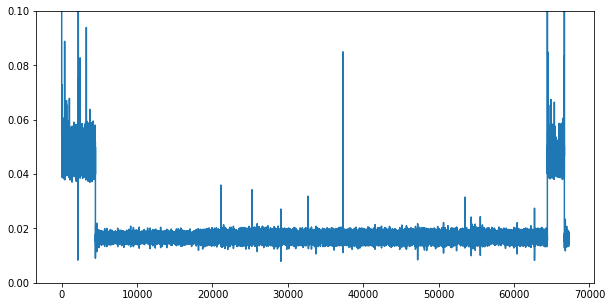

In [12]:
f, ax = plt.subplots()
ax.plot(dat)

ax.set_ylim(0, 0.1)
plt.gcf().set_size_inches(10, 5)

In [14]:
data = pd.read_csv('/Volumes/SteefSSD/IMCN-learningtask/IMCN-learningtask/data/sub-1_task-learning_datetime-20191016-131043_events.tsv', sep='\t')

0.36666666666666664

In [26]:
data.shape

(407, 25)

In [23]:
data

,trial_nr,onset,event_type,phase,response,nr_frames,stimulus_symbol_left,stimulus_symbol_right,correct_response,block_nr,...,rt,rt_too_slow,rt_too_fast,rt_in_time,choice_key,choice_direction,choice_outcome,total_points_earned,onset_abs,duration
0,0.0,1.126478,fix_cross_1,0.0,NaN,22.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501072,0.992898
1,0.0,2.119376,cue,1.0,NaN,22.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.493970,1.000099
2,0.0,3.000418,pulse,1.0,t,NaN,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375012,NaN
3,0.0,3.119475,fix_cross_2,2.0,NaN,21.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.494069,1.000000
4,0.0,4.119475,stimulus,3.0,NaN,30.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.494069,1.507035
5,0.0,4.562867,response,3.0,m,NaN,B,A,1.0,1.0,...,0.443392,False,False,True,m,1.0,1.0,100.0,5.937461,NaN
6,0.0,5.626510,fix_cross_3,4.0,NaN,0.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.001104,0.008921
7,0.0,5.635431,highlight,5.0,NaN,20.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.010025,1.002742
8,0.0,6.002402,pulse,5.0,t,NaN,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.376996,NaN
9,0.0,6.638173,fix_cross_4,6.0,NaN,0.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.012767,0.008395


In [22]:
data.loc[data.event_type == 'stimulus', 'nr_frames']

4      30.0
17     29.0
29     32.0
42     30.0
55     32.0
68     31.0
81     33.0
94     34.0
108    34.0
121    34.0
134    33.0
148    34.0
161    34.0
173    33.0
184    34.0
197    34.0
210    35.0
221    36.0
233    34.0
245    35.0
256    35.0
268    35.0
281    34.0
293    35.0
303    33.0
315    34.0
328    33.0
339    33.0
351    35.0
362    34.0
373    34.0
385    33.0
397    34.0
Name: nr_frames, dtype: float64

(array([2.1759e+04, 0.0000e+00, 0.0000e+00, 5.6000e+01, 0.0000e+00,
        2.1700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 1.6000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.9000e+01, 8.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.00777  , 0.0094655, 0.011161 , 0.0128565, 0.014552 , 0.0162475,
        0.017943 , 0.0196385, 0.021334 , 0.0230295, 0.024725 , 0.0264205,
        0.028116 , 0.0298115, 0.031507 , 0.0332025, 0.034898 , 0.0365935,
        0.038289 , 0.0399845, 0.04168  ]),
 <a list of 20 Patch objects>)

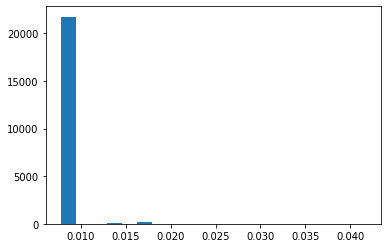

In [24]:
plt.hist(dat.round(5)[2:], bins=20)

In [32]:
1/120

0.008333333333333333

In [41]:
dat2 = dat[2:]
np.mean(dat2>0.02)

0.0031220306773449167

In [28]:
dat[2:].min()

0.007771199999751843

In [ ]:
# def counterbalance_stimuli(subject_id, all_sets):
#     """ switch sets = switch first and second half of the sets (useful for different block types) """
#     import itertools
#     from copy import deepcopy
    
#     n_sets = len(all_sets)
#     n_shifts = [0, 3, 6]  #np.arange(n_sets, dtype=int) #[0, 1, 2, 3, 4, 5, 6, 7, 8]
#     rev_inner = [False, True]
#     n_shifts_inner = [0, 1, 2]

#     cb_df = pd.DataFrame(list(itertools.product(n_shifts, rev_inner)),
#                          columns=['n_shifts', 'rev_inner'])
#     n_unique_permutations = cb_df.shape[0]
    
#     cb_df['pp'] = np.arange(1, cb_df.shape[0] + 1)
#     for stim_n in range(1, n_sets*2+1):  # loop over *stimuli*
#         cb_df['stim_%d' % stim_n] = None

#     for pp in cb_df['pp']:
#         idx = cb_df.pp == pp
#         reverse_inner = cb_df.loc[idx, 'rev_inner'].iloc[0]
#         n_shifts = cb_df.loc[idx, 'n_shifts'].iloc[0]

#         sets = deepcopy([all_sets])
    
#         sets_allocated = 0
#         for set_n, set_ in enumerate(sets):
#             for i in range(n_shifts):
#                 set_.insert(len(set_), set_.pop(0))  # move first item to last place
            
#             if reverse_inner:
#                 set_ = [x[::-1] for x in set_]  # reverse inner order

# #             print('pp %d, %d, %s' % (pp, set_n, set_))
#             #### NB: you could just use set_ as a final result; the placing in the dataframe and then reverting
#             # back to a nested list is definitely not necessary but may help clarify what's going on here...
#             for to_allocate in range(n_sets):
#                 for to_allocate_i in [0, 1]:
#                     cb_df.loc[idx, 'stim_%d' % (sets_allocated + 1)] = set_[to_allocate][to_allocate_i]
#                     sets_allocated += 1

#     pp_zero_based = int(subject_id) - 1
#     row_iloc = int(pp_zero_based - np.floor(pp_zero_based / n_unique_permutations) * n_unique_permutations)
#     colnames = cb_df.columns
#     stim_list = cb_df.iloc[row_iloc][[x for x in colnames if 'stim' in x]].values.tolist()
#     stim_nested_list = [[stim_list[0 + y * 2], stim_list[1 + y * 2]] for y in range(int(n_sets))]
#     print('Stimuli/set order for this pp: %s' % stim_nested_list)
#     return stim_nested_list

